# Two Nonlinear Two-Population Oscillators (with Periodic Perturbation)
## Model

The two populations' temporal dynamics (change of state) is described by two first-order linear differential equations:

$$ \frac{dEx_1}{dt}      = (h_{ex}      - Ex_1    - c_2*sigmoid(In_1) + c_{EE}*sigmoid((Ex_1 + frac_E*Ex_2)))*\tau_{ex} + pert$$
$$ \frac{dIn_1}{dt} \,\, = (h_{in} \,\, - In_1 \, - c_4*sigmoid(In_1) + c_{EI}*sigmoid((Ex_1 + frac_I*Ex_2)))*\tau_{in}$$

$$ \frac{dEx_2}{dt}      = (h_{ex}      - Ex_2    - c_2*sigmoid(In_2) + c_{EE}*sigmoid((Ex_2 + frac_E*Ex_1)))*\tau_{ex}$$
$$ \frac{dIn_2}{dt} \,\, = (h_{in} \,\, - In_2 \, - c_4*sigmoid(In_2) + c_{EI}*sigmoid((Ex_2 + frac_I*Ex_1)))*\tau_{in}$$

$Ex_i$ and $In_i$ are variables that change with time $t$ and represent the excitatory and inhibitory population, respectively.

$h_{ex}$ and $h_{in}$ are constant inputs to the populations. 
$c_2$ and $c_4$ are model parameters representing internal inhibitory coupling. 
$\tau_{ex}$ and $\tau_{in}$ are the poulation time constants.
$c_{EE}$ and $c_{EI}$ are self- and between population excitatory coupling parameters.

_pert_ represents an additive external perturbation.

Function _sigmoid_ is the continuous step function, conmputationally implemented as tangens hyperbolicus.


In [2]:
from scipy.integrate import odeint

from numpy import tanh, mod, linspace, around, zeros, mod
from numpy import sin, pi, var, ndarray, flip, arange

from numpy.random import default_rng, seed

from matplotlib.pyplot import subplots

import sk_dsp_comm.sigsys as ss

from scipy.signal import find_peaks

In [3]:
def sigmoid(u):
    return tanh(u)

def oscillator(y, t, N, h_ex, h_in, pars, frac_E, frac_I, sr, time_stop, pulse):

    tau_ex, tau_in, c2, c4, c_EE, c_EI = pars

    pulse_index = int(t*sr)

    if pulse_index >= time_stop*sr:

        dydt = zeros(2*N)

        return dydt

    else:

        if len(pulse) == 0:
    
            dydt = (
    
            
                (h_ex - y[0] - c2*sigmoid(y[1]) + c_EE*sigmoid((y[0]+frac_E*y[2])))*tau_ex,
                 
                (h_in - y[1] - c4*sigmoid(y[1]) + c_EI*sigmoid((y[0]+frac_I*y[2])))*tau_in,

                 
                (h_ex - y[2] - c2*sigmoid(y[3]) + c_EE*sigmoid((y[2]+frac_E*y[0])))*tau_ex,
                
                (h_in - y[3] - c4*sigmoid(y[3]) + c_EI*sigmoid((y[2]+frac_I*y[0])))*tau_in
               )

        # else:

        #     dydt = (
    
            
        #         (h_ex - y[0] + c1*y[0] - c2*y[1] + cc1*y[2])*tau_ex + pulse[pulse_index],
        #         (h_in - y[1] + c3*y[0] - c4*y[1] + cc2*y[2])*tau_in,
        #         (h_ex - y[2] + c1*y[2] - c2*y[3] + cc1*y[0])*tau_ex,
        #         (h_in - y[3] + c3*y[2] - c4*y[3] + cc2*y[0])*tau_in
        #        )
            
    return dydt


def plot_bifdiagram_scan(results, freq_set):

    no_scans = len(results)

    if freq_set[-1] < freq_set[0]:
        
        freq_set = flip(freq_set)

    freq_min, freq_max = freq_set[0], freq_set[-1]

    fig, ax  = subplots(nrows=no_scans, figsize=(5, 4))

    for index, result in enumerate(results):
    
        results_min_f, results_max_f = result[0], result[1] 
      
        for xe, ye in zip(freq_set, results_max_f[0]):
    
            if not isinstance(ye, ndarray):
                ax[index].scatter(xe, ye, c='r', s=5)
            else:
                ax[index].scatter([xe] * len(ye), ye, c='k', s=5, marker='o')
    
        for xe, ye in zip(freq_set, results_min_f[0]):
    
            if not isinstance(ye, ndarray):
                ax[index].scatter(xe, ye, c='r', s=5)
            else:
                ax[index].scatter([xe] * len(ye), ye, s=20,  c='b', marker='o', 
                                  facecolors='none', edgecolors='r')
    
        ax[index].set_xticks(linspace(freq_min, freq_max, 5));
        ax[index].set_xticklabels([]);
    
        ax[index].set_ylabel('Ex', fontsize=14)
    
        y_min, y_max = ax[index].get_ylim()

        # y_min, y_max = 0.5, 1.5

        ax[index].set_ylim(y_min, y_max)
        ax[index].set_yticks(linspace(y_min, y_max, 3))
        ax[index].set_yticklabels(around(linspace(y_min, y_max, 3)), fontsize=12)

    ax[index].set_xticks(linspace(freq_min, freq_max, 5));
    ax[index].set_xticklabels(around(linspace(freq_min, freq_max, 5), 2), fontsize=12);
    
    ax[index].set_xlabel('Parameter', fontsize=16)

    fig.tight_layout()
    
    return fig, ax


def plot_bifdiagram(results_min_f, results_max_f, 
                    par_set):
    
    N = len(results_min_f)

    fig, ax = subplots(figsize=(6, 4))

    for xe, ye in zip(par_set, results_max_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=6, marker='D')
        else:
            ax.scatter([xe] * len(ye), ye, s=3, c='k', marker='D')

    for xe, ye in zip(par_set, results_min_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=6, marker='d')
        else:
            ax.scatter([xe] * len(ye), ye, s=3, c='gray', marker='d')


    ax.set_xticks(linspace(par_set[0], par_set[-1], 5));
    ax.set_xticklabels(around(linspace(par_set[0], par_set[-1], 5), 2), fontsize=16);
    ax.set_xlabel('Parameter', fontsize=16)

    ax.set_ylabel('EX', fontsize=14)

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),2), fontsize=14);

    fig.tight_layout()
    
    return fig, ax

# Time Series

End of run: [2.635, -2.692, -0.905, -11.847]



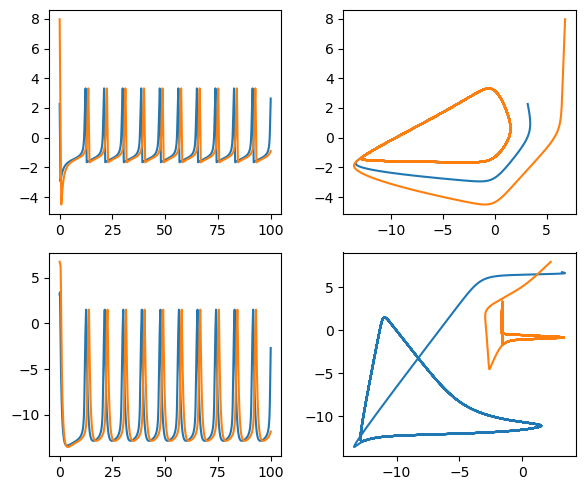

In [9]:
N = 2

# Input parameter
h_ex_0 = -6.9
h_in_0 = -4.0

# Oscillator parameters
# pars = (1, 2.5, 10, 0, 5, 10) # Homoclinic
pars = (1, 1.5, 10, 0, 5, 10) # SNIC
# t_ex, t_in, c2, c4, cc_EE, cc_EI

# Strong synchronisation
# frac_E, frac_I = 0.5, 0.0 # < 1. 0 means no coupling

# Temporary desynchronisation
# frac_E, frac_I = 0.0, 0.5 # < 1. 0 means no coupling
frac_E, frac_I = 0.0, 0.0 # < 1. 0 means no coupling

# Initial conditions
SEED = 12345
rng  = default_rng(SEED)
y_ini = rng.uniform(size=2*N)*10

# Time array
time_stop = 100
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

pulse = []

# Simulation
y = odeint(func=oscillator, y0=y_ini, t=time, 
          args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
          hmax=0.1)

# Resetting of initial conditions
y_ini = y[-1, :]

# Show final values of all variables
print('End of run:', list(around(y[-1,:],3)))
print('')

fig, ax = subplots(ncols=2, nrows=2, figsize=(6, 5))

ax[0, 0].plot(time, y[:, [0, 2]]);
ax[0, 1].plot(y[:, [1, 3]], y[:, [0, 2]]);
ax[1, 0].plot(time, y[:, [1, 3]]);
ax[1, 1].plot(y[:, [1, 0]], y[:, [3, 2]]);

if frac_E > 0 and frac_I == 0:
    
    chars = 'E-E cross-coupling'
    fig.suptitle(chars)

elif frac_E == 0 and frac_I > 0:
    
    chars = 'E-I cross-coupling'
    fig.suptitle(chars)

# elif pars[3] == 10 and pars[6] > 0:
    
#     chars = 'Fast with E-E coupling'
#     fig.suptitle(chars)

# elif pars[3] == 10 and pars[7] > 0:
    
#     chars = 'Fast with E-I coupling'
#     fig.suptitle(chars)
    
fig.tight_layout()



# Bifurcation Diagram with Coupling

In [159]:
# Oscillator parameters
# pars = (1, 1, 10, 0, 5, 10) # Fast
# t_ex, t_in, c2, c4, cc_EE, cc_EI

# Bifurcation parameter set
steps = 30

# par_min, par_max = -6.5, -7.5
par_min, par_max = -7.5, -6.5
par_set = linspace(par_min, par_max, steps)

# Time array
time_stop = 500
time = linspace(start=0, stop=time_stop, num=time_stop*sr)

results_min_f      = dict()
results_min_inds_f = dict()
results_max_f      = dict()
results_max_inds_f = dict()

rows = time.size

pulse = []

# Simulation "forward"
for par in par_set:
      
    y_pert = odeint(func=oscillator, y0=y_ini, t=time, 
                  args=(N, par, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
                  hmax=0.1)
# y = odeint(func=oscillator, y0=y_ini, t=time, 
#           args=(N, h_ex_0, h_in_0, pars, frac_E, frac_I, sr, time_stop, pulse), 
#           hmax=0.1)

    for num, series in enumerate(y_pert[rows//2:,:-1:2].T):
                
        if var(series) < 0.0001:
    
            if num not in results_min_f:
                
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
               
            else:
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)    

            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
               
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    

        else:
            
            y_f_max_inds = find_peaks(series, distance=100)
            y_f_maxs     = series[y_f_max_inds[0]]

            y_f_min_inds = find_peaks(-series, distance=100)
            y_f_mins     = series[y_f_min_inds[0]]

            if num not in results_min_f:

                results_min_f[num]      = [y_f_mins]
                results_min_inds_f[num] = [y_f_min_inds]
                
                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]

            else:

                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)
                
                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)


    if par != par_set[-1]:
        
        y_ini = y_pert[-1, :]

print('')
print('Scan complete!', list(around(y_pert[-1,:],3)))
print('')


Scan complete! [-1.252, -10.077, -1.252, -10.077]



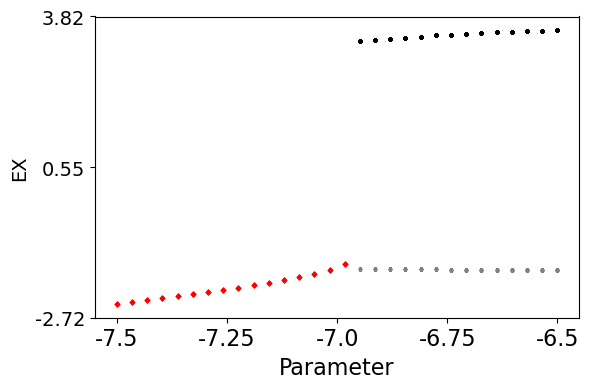

In [160]:
fig, ax = plot_bifdiagram(results_min_f, results_max_f, par_set)


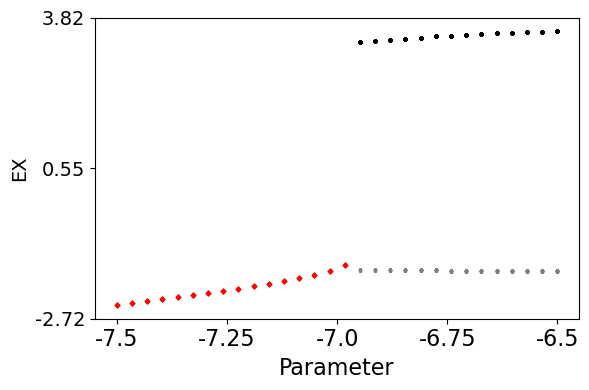

In [157]:
# Plot
fig, ax = plot_bifdiagram(results_min_f, results_max_f, par_set)


# Periodic Perturbation with Coupling

In [12]:
# Oscillator parameters
# pars = (1, 1, 0, 1, 1, 0, 1, 0) # Slow with E-E
# pars = (1, 1, 0, 1, 1, 0, 0, 10) # Slow with E-I
pars = (1, 1, 0, 10, 10, 0, 1, 0) # Fast with E-E
# pars = (1, 1, 0, 10, 10, 0, 0, 10) # Fast with E-I

# Input parameter
h_ex_set = (-2., -2.5)

# Initial conditions
SEED = 12345
rng  = default_rng(SEED)
y_in = rng.uniform(size=2*N)

# Time array
time_stop = 100
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

pulse = []

rows = time.size

y_in_sets = list()

for step, h_ex in enumerate(h_ex_set):
    
# Simulation
    y = odeint(func=oscillator, y0=y_in, t=time, 
                  args=(N, h_ex, h_in_0, pars, sr, time_stop, pulse), 
                  hmax=0.1)

# Resetting of initial conditions
    y_in = y[-1, :]
    y_in_sets.append(y_in)

# Show final values of all variables
print('End of run:', list(around(y[-1,:],3)))
print(y_in_sets)


End of run: [0.375, -0.25, 0.375, -0.25]
[array([ 0.38, -0.2 ,  0.38, -0.2 ]), array([ 0.375, -0.25 ,  0.375, -0.25 ])]


In [13]:
# Bifurcation parameter set
steps = 30
freq_min, freq_max = 0.5, 2.5
freq_set = linspace(freq_min, freq_max, steps)

# Time array
time_stop = 100
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

pulse_wid = 0.5
pulse_amp = 2.

results = list()

for step, h_ex in enumerate(h_ex_set):
    
    results_min_f      = dict()
    results_min_inds_f = dict()
    results_max_f      = dict()
    results_max_inds_f = dict()
    
    # Simulation "forward"
    for freq in freq_set:
        
        pulse = pulse_amp*ss.rect(mod(time, 1/freq)-(1/freq)/2-pulse_wid/2, pulse_wid)

        y_pert = odeint(func=oscillator, y0=y_in_sets[step], t=time, 
                        args=(N, h_ex, h_in_0, pars, sr, time_stop, pulse), 
                        hmax=0.1)


        for num, series in enumerate(y_pert[rows//2:,:-1:2].T):
                    
            if var(series) < 0.0001:
        
                if num not in results_min_f:
                    
                    results_min_f[num]      = [series[-1]]
                    results_min_inds_f[num] = [0]    
                   
                else:
                    results_min_f[num].append(series[-1])
                    results_min_inds_f[num].append(0)    
    
                if num not in results_max_f:
                    
                    results_max_f[num]      = [series[-1]]
                    results_max_inds_f[num] = [0]    
                   
                else:
                    results_max_f[num].append(series[-1])
                    results_max_inds_f[num].append(0)    
    
            else:
                
                y_f_max_inds = find_peaks(series, distance=100)
                y_f_maxs     = series[y_f_max_inds[0]]
    
                y_f_min_inds = find_peaks(-series, distance=100)
                y_f_mins     = series[y_f_min_inds[0]]
    
                if num not in results_min_f:
    
                    results_min_f[num]      = [y_f_mins]
                    results_min_inds_f[num] = [y_f_min_inds]
                    
                    results_max_f[num]      = [y_f_maxs]
                    results_max_inds_f[num] = [y_f_max_inds]
    
                else:
    
                    results_min_f[num].append(y_f_mins)
                    results_min_inds_f[num].append(y_f_min_inds)
                    
                    results_max_f[num].append(y_f_maxs)
                    results_max_inds_f[num].append(y_f_max_inds)

        # if par != par_set[-1]:
            
        #     y_in = y_pert[-1, :]

    results.append((results_min_f, results_max_f))

print('')
print('Scan complete!')
print('')



Scan complete!



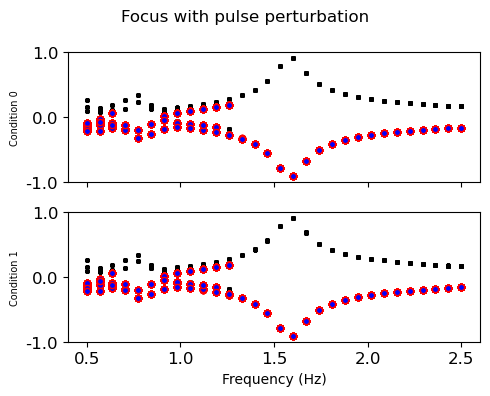

In [14]:
# Plot
fig, ax = plot_bifdiagram_scan(results, freq_set)

for condition in arange(len(h_ex_set)):

    ax[condition].set_ylabel('Condition ' + str(condition), fontsize=7)
    
ax[-1].set_xlabel('Frequency (Hz)', fontsize=10);


if pars[3] == 1:
    
    chars = 'Slow with pulse perturbation'
    fig.suptitle(chars)

elif pars[3] == 10:
    
    chars = 'Fast with pulse perturbation'
    fig.suptitle(chars)

fig.tight_layout()

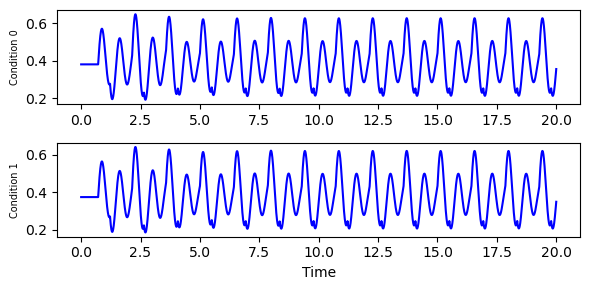

In [15]:
# Time array
time_stop = 20
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

rows = time.size

freq       = 0.7

fig, ax = subplots(nrows=len(h_ex_set), figsize=(6, 3))

for condition, h_ex in enumerate(h_ex_set):

    y_in = y_in_sets[condition]
    h_ex = h_ex_set[condition]

    pulse = pulse_amp*ss.rect(mod(time, 1/freq)-(1/freq)/2-pulse_wid/2, pulse_wid)


    y_pert = odeint(func=oscillator, y0=y_in, t=time, 
                    args=(N, h_ex, h_in_0, pars, sr, time_stop, pulse), 
                    hmax=0.1)

    
    ax[condition].plot(time, y_pert[:, 0], c='b')
    # ax[condition].set_ylim(-3, 4)
    ax[condition].set_ylabel('Condition ' + str(condition), fontsize=7)


ax[condition].set_xlabel('Time');

fig.tight_layout()


# Test Code

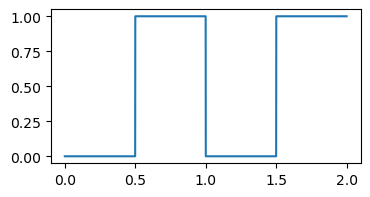

In [18]:
pulse_wid = 0.5
pulse_amp = 1.0

freq = 1

pulse_per = 1/freq
# pulse     = pulse_amp*ss.rect(mod(time, pulse_per)-pulse_per/2+pulse_wid/2, pulse_wid)
pulse     = pulse_amp*ss.rect(mod(time, pulse_per)-pulse_per/2-pulse_wid/2, pulse_wid)

fig, ax = subplots(figsize=(4, 2))

ax.plot(time[:2000], pulse[:2000]);